In [95]:
import evaluate
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

bleu = evaluate.load("bleu")

### BLEU

The BLEU (Bilingual Evaluation Understudy) metric calculates its score by looking at the overlap between the words and phrases in the machine-translated text and the reference translation. It counts the number of matching words and gives higher weight to longer matches. Then, it calculates a precision score based on these matches. Finally, it combines these precision scores to give an overall BLEU score, which indicates how well the machine translation matches the reference translation.\
\
https://www.baeldung.com/cs/nlp-bleu-score

In [131]:
# reading the dataset and printing the prompts used for translation 

file_path = 'mt_for_eval.json'

with open(file_path, 'r') as json_file:
    translation_data = json.load(json_file)

prompts = set()

for label in translation_data.values():
    label_prompts = list(label.keys())
    prompts.update(label_prompts)

prompt_names = {}

for num, prompt in enumerate(prompts):
     prompt_name = 'Prompt '+str(num+1)
     prompt_names[prompt] = prompt_name
     print(prompt_name, '\n', prompt)

Prompt 1 
 You are an expert translator that will be tasked with translating a piece of text into Russian. The translation must be faithful to the original tone of voice and writing style. Ensure that the meaning of the original text is not changed. The text to be translated is:
Prompt 2 
 You are an expert translator. Translate the following text to Russian using vocabulary and expressions of a Russian native. The text to be translated is:


In [128]:
# creating lists of values from the dataset for evaluation on BLEU

data_bleu = []

for label, prompts in translation_data.items():
    for prompt, translations in prompts.items():
        machine_translations = []
        human_translations = []
        for translation in translations:
            machine_translations.append(translation[1])
            human_translations.append(translation[2])

        data_bleu.append([label, prompt_names[prompt], [machine_translations, human_translations]])

In [129]:
# calculating the BLEU scores

for item in data_bleu:
    predictions = item[2][0]
    references = item[2][1]
    results = bleu.compute(predictions=predictions, references=references)
    bleu_score = results['bleu']
    item.append(bleu_score)

df_bleu = pd.DataFrame(data_bleu, columns = ['label', 'prompt', 'translations', 'bleu_score'])
df_bleu.drop(columns=['translations'], axis=1, inplace=True)
df_bleu

,label,prompt,bleu_score
0,literature,Prompt 2,0.147939
1,literature,Prompt 1,0.147648
2,medical,Prompt 2,0.201215
3,medical,Prompt 1,0.192895
4,law,Prompt 2,0.178645
5,law,Prompt 1,0.176438


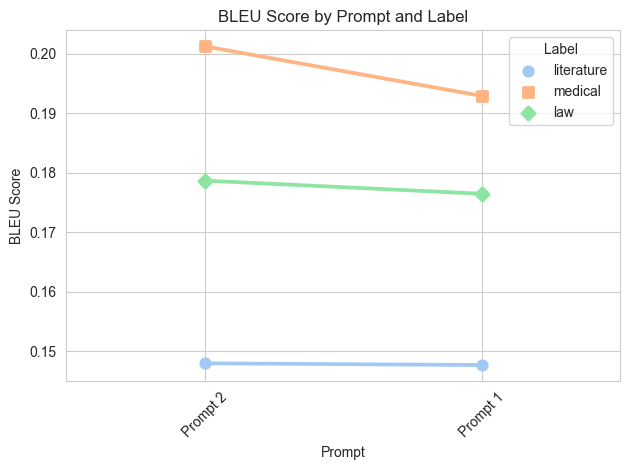

In [126]:
# plotting the results

sns.pointplot(data=df_bleu, x='prompt', y='bleu_score', hue='label', dodge=False, markers=["o", "s", "D"], palette='pastel')
plt.title('BLEU Score by Prompt and Label')
plt.xlabel('Prompt')
plt.ylabel('BLEU Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Label')
plt.grid(True)  # Add grid
plt.show()

### COMET

COMET (Crosslingual Optimized Metric for Evaluation of Translation) is a metric for automatic evaluation of machine translation that calculates the similarity between a machine translation output and a reference translation using token or sentence embeddings.
It is based on similarity of vector representations. \
A score close to 1 indicates a high-quality translation, while a score close to 0 indicates a translation that is no better than random chance.

In [46]:
from comet import download_model, load_from_checkpoint

model_path = download_model("Unbabel/wmt22-comet-da")  # default COMET model

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 5068.03it/s]


In [47]:
# Load the model checkpoint:
model = load_from_checkpoint(model_path)

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\svvlk\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
Encoder model frozen.
c:\Users\svvlk\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\core\saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [132]:
# converting the data into the format accepted by the COMET model

data_comet = translation_data.copy()

for label, prompts in data_comet.items():
    for prompt, translations in prompts.items():
        comet_translations = []
        for translation in translations: 
            comet_translation = {"src": translation[0], "mt": translation[1], "ref": translation[2]}
            comet_translations.append(comet_translation)
        data_comet[label][prompt] = comet_translations

In [130]:
# calculating the COMET scores

comet_scores = []

for label, prompts in data_comet.items():
    for prompt, translations in prompts.items():
        model_output = model.predict(translations, batch_size=8, gpus=0)
        comet_score = [label, prompt_names[prompt], model_output['system_score']]
        comet_scores.append(comet_score)
        
df_comet = pd.DataFrame(comet_scores, columns = ['label', 'prompt', 'comet_score'])
df_comet

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 20/20 [01:02<00:00,  3.11s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Predicting DataLoader 0: 100%|██████████| 20/20 [01:08<00:00,  3.45s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Predicting DataLoader 0: 100%|██████████| 10/10 [00:42<00:00,  4.26s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Predicting DataLoader 0: 100%|██████████| 11/11 [00:44<00:00,  4.05s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Predicting DataLoader 0: 100%|██████████| 10/10 [00:48<00:00,  4.84s/it]
GPU available: False, used: False
TPU available

,label,prompt,comet_score
0,literature,Prompt 2,0.821362
1,literature,Prompt 1,0.825643
2,medical,Prompt 2,0.862352
3,medical,Prompt 1,0.857635
4,law,Prompt 2,0.859116
5,law,Prompt 1,0.844236


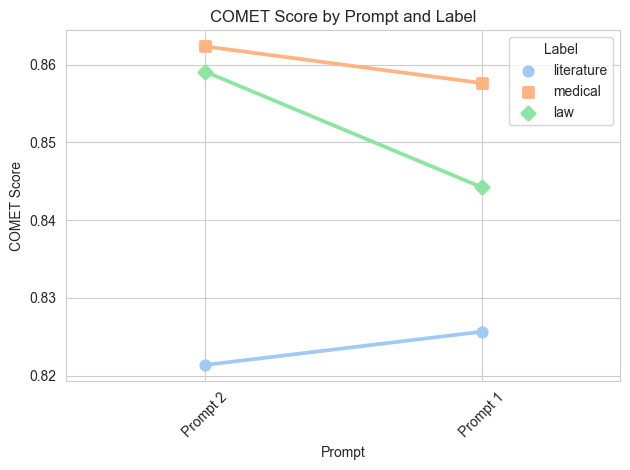

In [124]:
# plotting the results

sns.pointplot(data=df_comet, x='prompt', y='comet_score', hue='label', dodge=False, markers=["o", "s", "D"], palette='pastel')
plt.title('COMET Score by Prompt and Label')
plt.xlabel('Prompt')
plt.ylabel('COMET Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Label')
plt.grid(True)  # Add grid
plt.show()

### Conclusions

The evaluation of the dataset using COMET and BLEU metrics revealed trends in the performance of the GPT-3.5-turbo model across different types of texts. It appears that the model excels in translating medical texts, showing slightly weaker performance with legal texts. Across both domains, Prompt 2 consistently proved to be more effective.

Predictably, literary texts received the lowest scores overall, with Prompt 1 showing slightly better results on average. These findings suggest that the model's performance varies depending on the type of text, highlighting the need for tailored approaches when applying it to different domains. 